# <b>DS3000 Group Project</b>

# <b>Chef.AI</b> - Lukas Bozinov & Arjun Atwal - Group 31

## Section 0 - Preliminary Code

### Section 0.1: Import all necessary libraries

In [10]:
import numpy as np #etc etc etc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import csv, ast, math, os
from groq import Groq
from dotenv import load_dotenv

## Section 1 - Organization of Dataset

### Section 1.1: Parse the dataset
Formatting data into a format that is easily passed to math functions.

In [11]:
# written by lukas (i am the goat)

load_dotenv()
a=os.getenv("OPENAI_API_KEY")
print(a)

class Food:
    def __init__(self, food_name, food_group, colour_day, mass_day, temp_day):
        self.food_name = food_name
        self.food_group = food_group
        self.colour_day = colour_day
        self.mass_day = mass_day
        self.temp_day = temp_day

    def __str__(self):
        return (
            f"Food Name: {self.food_name}\n"
        )

foodList_train = []

with open('ourData.csv', "r") as commentedFile: 
    reader = csv.reader(commentedFile)
    next(reader)  # skip line of headers

    for row in reader:
        food_name = row[0].strip()
        food_group = row[1].strip()
        colour_day_raw = row[2].strip()
        mass_day_raw = row[3].strip()
        temp_day_raw = row[4].strip()

        colour_day_list = ast.literal_eval(colour_day_raw)
        mass_day_list = ast.literal_eval(mass_day_raw)
        temp_day_list = ast.literal_eval(temp_day_raw)

        # Use lists instead of dictionaries because duplicate values erases entries that we need
        colour_day = colour_day_list
        mass_day = mass_day_list
        temp_day = temp_day_list

        food = Food(food_name, food_group, colour_day, mass_day, temp_day)

        foodList_train.append(food)

# get total number of days for later processing
numDays_train = len(foodList_train[0].colour_day)

#TEST

foodList_test = []

with open('ourDataTest.csv', "r") as commentedFile: 
    reader = csv.reader(commentedFile)
    next(reader)  # skip line of headers

    for row in reader:
        food_name = row[0].strip()
        food_group = row[1].strip()
        colour_day_raw = row[2].strip()
        mass_day_raw = row[3].strip()
        temp_day_raw = row[4].strip()

        colour_day_list = ast.literal_eval(colour_day_raw)
        mass_day_list = ast.literal_eval(mass_day_raw)
        temp_day_list = ast.literal_eval(temp_day_raw)

        # Use lists instead of dictionaries because duplicate values erases entries that we need
        colour_day = colour_day_list
        mass_day = mass_day_list
        temp_day = temp_day_list

        food = Food(food_name, food_group, colour_day, mass_day, temp_day)

        foodList_test.append(food)

# get total number of days for later processing
numDays_test = len(foodList_test[0].colour_day)



None


### Section 1.2: Data Pre-Processing
Passing Data to math functions to create mass factors

In [12]:
# import deez

def freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal, weight_mass = 0.5, weight_temp = 0.3, weight_color = 0.2, alpha = 0.3, sigma = 5, lambda_ = 0.05):

    # Mass Factor - not certain about this
    mass_factor = (math.exp(-alpha * time * (mass_curr / mass_initial))) * weight_mass
    # print(mass_factor)

    # Temperature Factor
    temp_factor = math.exp(-((temp_curr - temp_optimal) ** 2) / (2 * sigma ** 2)) * weight_temp
    # print(temp_factor)

    # Color Factor - asm color_curr, color_optimal are in range RGB(0-255, 0-255, 0-255)
    color_diff = math.sqrt((color_curr[0] - color_optimal[0]) ** 2 + (color_curr[1] - color_optimal[1]) ** 2 + (color_curr[2] - color_optimal[2]) ** 2)
    color_factor = math.exp(-lambda_ * color_diff) * weight_color
    # print(color_factor)

    # Freshness Index
    freshness_index = mass_factor + temp_factor + color_factor
    return min(1, freshness_index) # with the weights summing to 1, the maximum value of the freshness index is 1

def train_freshness_index(food_name):

    # find the food object
    food = None
    for i in range(len(foodList_train)):
        if foodList_train[i].food_name == food_name:
            food = foodList_train[i]
            break

    if food == None:
        print('Food not found')
        exit()

    # find the index of the food object
    food_index = foodList_train.index(food)

    # initialize optimal values for the freshness_index function
    color_optimal = (foodList_train[food_index].colour_day[0][0])
    temp_optimal = foodList_train[food_index].temp_day[0][0]
    mass_initial = foodList_train[food_index].mass_day[0][0]

    days = []
    for i in range(numDays_train):
        days.append(i)

        #freshness_values = np.array([1.0, 0.710923868536591, 0.63709970475181, 0.511606076772564, 0.44434784966860497, 0.40576335646495826, 0.381205757697219])

    days = np.array(days)

    freshness_values_train = []

    for i in range(numDays_train):
        color_curr = (foodList_train[food_index].colour_day[i][0])
        temp_curr = foodList_train[food_index].temp_day[i][0]
        mass_curr = foodList_train[food_index].mass_day[i][0]
        time = i

        print('Time =', time)
        freshnessindex_train = freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal)
        print(freshnessindex_train)
        freshness_values_train.append(freshnessindex_train)

    freshness_values_train = np.array(freshness_values_train)

    print(days)
    print(freshness_values_train)
    return days, freshness_values_train

def test_freshness_index(food_name):

    #TEST - dont need to ask for food name again

    # find the food object
    food = None
    for i in range(len(foodList_test)):
        if foodList_test[i].food_name == food_name:
            food = foodList_test[i]
            break

    if food == None:
        print('Food not found')
        exit()

    # find the index of the food object
    food_index = foodList_test.index(food)

    # initialize optimal values for the freshness_index function
    color_optimal = (foodList_test[food_index].colour_day[0][0])
    temp_optimal = foodList_test[food_index].temp_day[0][0]
    mass_initial = foodList_test[food_index].mass_day[0][0]

    days_test = []
    for i in range(numDays_test):
        days_test.append(i)

        #freshness_values = np.array([1.0, 0.710923868536591, 0.63709970475181, 0.511606076772564, 0.44434784966860497, 0.40576335646495826, 0.381205757697219])

    days_test = np.array(days_test)

    freshness_values_test = []

    for i in range(numDays_test):
        color_curr = (foodList_test[food_index].colour_day[i][0])
        temp_curr = foodList_test[food_index].temp_day[i][0]
        mass_curr = foodList_test[food_index].mass_day[i][0]
        time = i

        print('Time =', time)
        freshnessindex_test = freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal)
        print(freshnessindex_test)
        freshness_values_test.append(freshnessindex_test)

    freshness_values_test = np.array(freshness_values_test)

    print(days_test)
    print(freshness_values_test)
    return days_test, freshness_values_test



## Section 2 - Mathematical Function Initialization

### Section 2.1: Sigmoid Function Declaration

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

def freshness_sigmoid_model(t, L, k, t_0):
    return L / (1 + np.exp(-k * (t - t_0)))



def sigmoid_model_regression(days, freshness_values_train, days_test, freshness_values_test):

    # Assuming days, days_test, freshness_values_train, and freshness_values_test are already defined. 
    days_train = days
    freshness_train = freshness_values_train
    days_test = days_test
    freshness_test = freshness_values_test

    # Provide initial parameter guesses and increase maxfev
    initial_guesses = [1, 1, 12]

    params, covariance = curve_fit(
        freshness_sigmoid_model,
        days_train,
        freshness_train,
        p0=initial_guesses,
        maxfev=20000
    )

    L, k, t_0 = params

    predicted_train = freshness_sigmoid_model(days_train, L, k, t_0)
    predicted_test = freshness_sigmoid_model(days_test, L, k, t_0)

    mse_train = mean_squared_error(freshness_train, predicted_train)
    mse_test = mean_squared_error(freshness_test, predicted_test)

    print(f"Mean Squared Error on Training Data: {mse_train}")
    print(f"Mean Squared Error on Test Data: {mse_test}")

    r2_train = r2_score(freshness_train, predicted_train)
    r2_test = r2_score(freshness_test, predicted_test)

    print(f"R^2 on Training Data: {r2_train}")
    print(f"R^2 on Test Data: {r2_test}")

    days_extended = np.linspace(0, 24, 100)
    predicted_freshness = freshness_sigmoid_model(days_extended, L, k, t_0)

    # Find the day when the freshness index equals 0.8, 0.6, and 0.4
    target_values = [0.8, 0.6, 0.4]
    target_days = {}

    for target in target_values:
        closest_day = None
        closest_diff = float('inf')
        for i in range(len(predicted_freshness)):
            diff = abs(predicted_freshness[i] - target)
            if diff < closest_diff:
                closest_diff = diff
                closest_day = days_extended[i]
        target_days[target] = closest_day

    for target, day in target_days.items():
        print(f"Day when freshness index is closest to {target}: {day}")

    plt.scatter(days, freshness_values_train, color='blue', label='Observed Data Points')
    plt.plot(days_extended, predicted_freshness, color='red', label='Nonlinear Sigmoid Decay Curve')
    plt.xlabel('Days')
    plt.ylabel('Freshness Index')
    plt.title('Nonlinear Freshness Index Decay with Expected Spoilage at Day 7')
    plt.legend()
    plt.show()

    return target_days

# sigmoid_model_regression()

### Section 2.2: Life coach for meals so i guess just the chef part?

Time = 0
1
Time = 1
0.710923868536591
Time = 2
0.63709970475181
Time = 3
0.511606076772564
Time = 4
0.44434784966860497
Time = 5
0.40576335646495826
Time = 6
0.381205757697219
[0 1 2 3 4 5 6]
[1.         0.71092387 0.6370997  0.51160608 0.44434785 0.40576336
 0.38120576]
Time = 0
1
Time = 1
0.7131630360573626
Time = 2
0.6425531404188921
Time = 3
0.4948446994286173
Time = 4
0.46135035350384773
Time = 5
0.38234044107776954
Time = 6
0.380944703280409
[0 1 2 3 4 5 6]
[1.         0.71316304 0.64255314 0.4948447  0.46135035 0.38234044
 0.3809447 ]
Mean Squared Error on Training Data: 0.0021799151339045512
Mean Squared Error on Test Data: 0.002223782781585922
R^2 on Training Data: 0.9473125773522019
R^2 on Test Data: 0.9477694116058286
Day when freshness index is closest to 0.8: 0.9696969696969697
Day when freshness index is closest to 0.6: 2.4242424242424243
Day when freshness index is closest to 0.4: 4.848484848484849


C:\Users\Arjun\AppData\Local\Temp\ipykernel_11248\1039339099.py:7: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (t - t_0)))


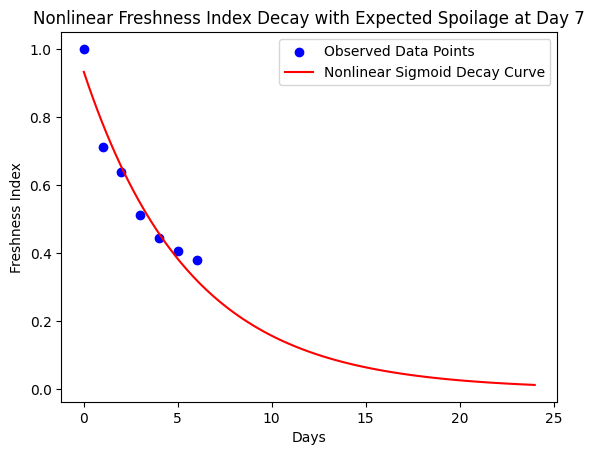

Time = 0
1
Time = 1
0.7078775120271888
Time = 2
0.5778485465357864
Time = 3
0.5016814424216284
Time = 4
0.4536541194342206
Time = 5
0.4146433553635352
Time = 6
0.38054662085438773
[0 1 2 3 4 5 6]
[1.         0.70787751 0.57784855 0.50168144 0.45365412 0.41464336
 0.38054662]
Time = 0
1
Time = 1
0.7094647218017864
Time = 2
0.577519332634822
Time = 3
0.501701310573873
Time = 4
0.45348056022819955
Time = 5
0.41462651350654917
Time = 6
0.3804836543024271
[0 1 2 3 4 5 6]
[1.         0.70946472 0.57751933 0.50170131 0.45348056 0.41462651
 0.38048365]
Mean Squared Error on Training Data: 0.0030869068792972704
Mean Squared Error on Test Data: 0.0030641790591056464
R^2 on Training Data: 0.9233469985972416
R^2 on Test Data: 0.9240429261577978
Day when freshness index is closest to 0.8: 0.7272727272727273
Day when freshness index is closest to 0.6: 2.4242424242424243
Day when freshness index is closest to 0.4: 4.606060606060606


C:\Users\Arjun\AppData\Local\Temp\ipykernel_11248\1039339099.py:7: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (t - t_0)))


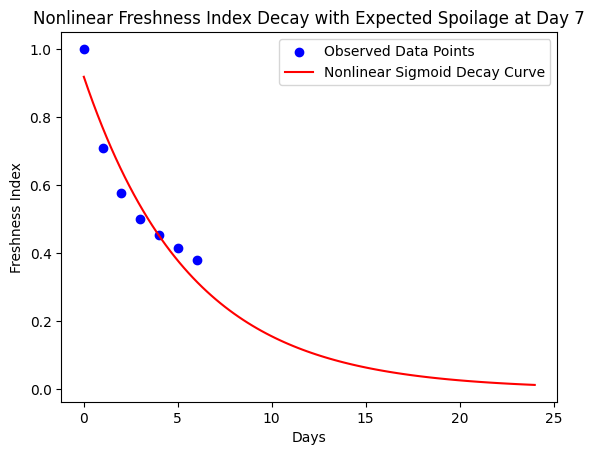

Time = 0
1
Time = 1
0.8726382457216444
Time = 2
0.695518518250311
Time = 3
0.5078117297636942
Time = 4
0.46383657719623816
Time = 5
0.4221520671368199
Time = 6
0.3741702478887078
[0 1 2 3 4 5 6]
[1.         0.87263825 0.69551852 0.50781173 0.46383658 0.42215207
 0.37417025]
Time = 0
1
Time = 1
0.8447577047386869
Time = 2
0.6557712348717788
Time = 3
0.4577902486009087
Time = 4
0.4683203035838363
Time = 5
0.40705018433047535
Time = 6
0.3511833681365167
[0 1 2 3 4 5 6]
[1.         0.8447577  0.65577123 0.45779025 0.4683203  0.40705018
 0.35118337]
Mean Squared Error on Training Data: 0.0012624373281904058
Mean Squared Error on Test Data: 0.002394813002845474
R^2 on Training Data: 0.9747855653478839
R^2 on Test Data: 0.9533936154342847
Day when freshness index is closest to 0.8: 1.2121212121212122
Day when freshness index is closest to 0.6: 2.909090909090909
Day when freshness index is closest to 0.4: 5.090909090909091


C:\Users\Arjun\AppData\Local\Temp\ipykernel_11248\1039339099.py:7: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (t - t_0)))


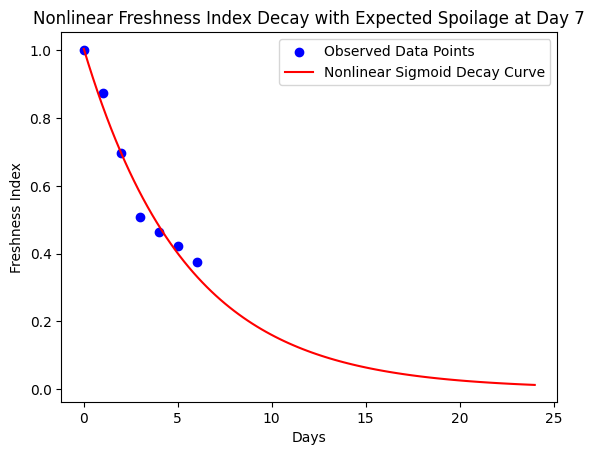

In [29]:
# take target_days which contains the days when the freshness index is closest to 0.8, 0.6, and 0.4
# these are our categories, anything before 0.8 is good to eat, anything between 0.8 and 0.6 is okay to eat, and anything after 0.6 is bad to eat
# loop the above for all foods (or however many we wish to analyze) and store the results in a dictionary or something
# then, simply go week by week
# optimize meal planning based on this information

inputted_foods = []
freshness_values_per_food = []

try:
    n = int(input('How many foods would you like to analyze? For best results, enter a number above 3: '))
except ValueError:
    print("Invalid input. Please enter a valid number.")
    n = int(input('How many foods would you like to analyze? '))

for item in range(n):
    # which food are we looking at
    for i in range(len(foodList_train)):  # print all options
        food_options = [foodList_train[i].food_name for i in range(len(foodList_train))]
    food_name = input('\nEnter the name of the food you would like to analyze:\nOptions are ' + ', '.join(food_options) + '\n')

    inputted_foods.append(food_name)

    train_values = train_freshness_index(food_name)
    test_values = test_freshness_index(food_name)
    freshness_values = sigmoid_model_regression(train_values[0], train_values[1], test_values[0], test_values[1])
    freshness_values_per_food.append((food_name, freshness_values))

# print(freshness_values_per_food)


    
    





## Section 3 - ChatGPT wrapper

Which Foods to use First


In [ ]:
num_recs = len(freshness_values_per_food)
num_recs_08 = math.ceil(num_recs)
num_recs_06 = math.floor(num_recs)
num_recs_04 = math.floor(num_recs)

# for 0.8
recs_08 = []
for i in range(num_recs_08):
    min_08 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.8] < min_08:
            min_08 = food[1][0.8]
            min_food = food
    recs_08.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print(recs_08)

# for 0.6
recs_06 = []
for i in range(num_recs_06):
    min_06 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.6] < min_06:
            min_06 = food[1][0.6]
            min_food = food
    recs_06.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print(recs_06)

# for 0.4
recs_04 = []
for i in range(num_recs_04):
    min_04 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.4] < min_04:
            min_04 = food[1][0.4]
            min_food = food
    recs_04.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print(recs_04)

final_recs = []
for i in range(num_recs):
    if recs_08[i] == recs_06[i] == recs_04[i]:
        final_recs.append(recs_08[i])
print(final_recs)


    



['Apple', 'Pineapple', 'Naan Bread']


ValueError: list.remove(x): x not in list

### Section 3.1: Do the thing

In [ ]:
prompt = ""
for i in inputted_foods:
    prompt += (i + ", ")



#print(os.getenv("OPENAI_API_KEY"))

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

client = Groq()


chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a chef."
        },
        {
            "role": "user",
            "content": "Give me a recipe that I can make that exclusively uses these ingredients: Do not use any other items except for common household items like seasoning, oil, etc." + prompt,
        }
    ],

    model="llama3-8b-8192"
)

print(chat_completion.choices[0].message.content)

GroqError: The api_key client option must be set either by passing api_key to the client or by setting the GROQ_API_KEY environment variable

### Section 3.2: Fit model

In [ ]:
print('model.fit go brrrrr')

model.fit go brrrrr


### Section 3.3: Evaluate accuracy

In [ ]:
print('auroc man idk')

auroc man idk


## Section 4 - Visualization

### Section 4.1: Line graph

In [ ]:
print('something something matplotlib')

something something matplotlib


### Section 4.2: Other visualization

In [ ]:
print('something something seaborn')

something something seaborn


## Section 5 - Comparisons to other models (?)

### Section 5.1: Comparison to linear regression

In [ ]:
print('news flash: linear regression sucks')

news flash: linear regression sucks


## Section 6 - Conclusions to draw

In [ ]:
print('overall, our model is better than the other one')

overall, our model is better than the other one
